In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import os
import cv2
from PIL import Image as PILImage
import keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

In [21]:
!pip install scikit-image --quiet


In [22]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNEL = 3
BATCH_SIZE = 8
EPOCHS = 150
SEED = 13
smooth = 1.0

In [23]:
# Define directories for images and masks
image_directory = '/kaggle/input/betel-seg/Dataset for Segmentation/images'  # Update this path to your actual image directory
mask_directory = '/kaggle/input/betel-seg/Dataset for Segmentation/masks'  # Update this path to your actual mask directory


In [24]:
images = sorted(os.listdir(image_directory))
masks = sorted(os.listdir(mask_directory))


In [25]:
# Print image and corresponding mask names to check alignment
for i, image_name in enumerate(images[:5]):  # Checking first 5 examples
    mask_name = masks[i]
    print(f"Image: {image_name} -> Mask: {mask_name}")


Image: Bacterial_Leaf_Spot_Disease(1).jpg -> Mask: Bacterial_Leaf_Spot_Disease(1).png
Image: Bacterial_Leaf_Spot_Disease(10).jpg -> Mask: Bacterial_Leaf_Spot_Disease(10).png
Image: Bacterial_Leaf_Spot_Disease(100).jpg -> Mask: Bacterial_Leaf_Spot_Disease(100).png
Image: Bacterial_Leaf_Spot_Disease(101).jpg -> Mask: Bacterial_Leaf_Spot_Disease(101).png
Image: Bacterial_Leaf_Spot_Disease(102).jpg -> Mask: Bacterial_Leaf_Spot_Disease(102).png


In [26]:
image_basenames = [os.path.splitext(image)[0] for image in images]
mask_basenames = [os.path.splitext(mask)[0] for mask in masks]

# Check for missing masks
missing_masks = [image for image in image_basenames if image not in mask_basenames]

# Check for extra masks
extra_masks = [mask for mask in mask_basenames if mask not in image_basenames]

# Output results
print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")
print(f"Images missing masks: {len(missing_masks)}")
for missing in missing_masks:
    print(f"Missing mask for image: {missing}")

if extra_masks:
    print(f"\nExtra masks found ({len(extra_masks)}):")
    for extra in extra_masks:
        print(f"Extra mask without an image: {extra}")


Total images: 992
Total masks: 971
Images missing masks: 22
Missing mask for image: Bacterial_Leaf_Spot_Disease(167)
Missing mask for image: Bacterial_Leaf_Spot_Disease(193)
Missing mask for image: Bacterial_Leaf_Spot_Disease(236)
Missing mask for image: Bacterial_Leaf_Spot_Disease(247)
Missing mask for image: Bacterial_Leaf_Spot_Disease(33)
Missing mask for image: Bacterial_Leaf_Spot_Disease(53)
Missing mask for image: Bacterial_Leaf_Spot_Disease(54)
Missing mask for image: Bacterial_Leaf_Spot_Disease(61)
Missing mask for image: Bacterial_Leaf_Spot_Disease(62)
Missing mask for image: Bacterial_Leaf_Spot_Disease(66)
Missing mask for image: Bacterial_Leaf_Spot_Disease(71)
Missing mask for image: Bacterial_Leaf_Spot_Disease(81)
Missing mask for image: Bacterial_Leaf_Spot_Disease(82)
Missing mask for image: Bacterial_Leaf_Spot_Disease(85)
Missing mask for image: Bacterial_Leaf_Spot_Disease(88)
Missing mask for image: Bacterial_Leaf_Spot_Disease(93)
Missing mask for image: Bacterial_Leaf_S

In [27]:
# Filter out images without matching masks
valid_images = [image for image in images if os.path.splitext(image)[0] in mask_basenames]

# Filter out masks without matching images (optional, if needed)
valid_masks = [mask for mask in masks if os.path.splitext(mask)[0] in image_basenames]

# Output results
print(f"Total valid images for training: {len(valid_images)}")
print(f"Total valid masks for training: {len(valid_masks)}")

# # For confirmation (optional)
# for image, mask in zip(valid_images, valid_masks):
#     print(f"Image: {image} | Mask: {mask}")


Total valid images for training: 970
Total valid masks for training: 970


In [28]:
# from skimage.transform import resize
# import os
# import numpy as np
# from PIL import Image as PILImage
# import cv2
# from IPython.display import Image, display  # Import for displaying images in Jupyter

# # Define the size to which all images and masks will be resized
# IMG_HEIGHT = 256
# IMG_WIDTH = 256
# IMG_CHANNEL = 3  # For RGB images

# # Initialize lists to store the images and masks
# image_dataset = []
# mask_dataset = []

# # Ensure images and masks are sorted
# images = sorted(os.listdir(image_directory))
# masks = sorted(os.listdir(mask_directory))

# # Create a mapping of image filenames to mask filenames
# image_mask_map = {}
# for image_name in images:
#     if image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.tif'):
#         base_name = os.path.splitext(image_name)[0]
#         corresponding_mask = f"{base_name}.png"  # Assuming masks are in .png format
#         image_mask_map[image_name] = corresponding_mask

# # Load and process the images and masks
# for image_name, mask_name in image_mask_map.items():
#     if mask_name in masks:
#         # Read and process image
#         image_path = os.path.join(image_directory, image_name)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize using skimage
#         image = image.astype(np.uint8)  # Ensure the dtype is uint8
#         image_dataset.append(image)

#         # Display the image using IPython's Image
#         #display(PILImage.fromarray(image))  # For visualization in Jupyter

#         # Read and process mask
#         mask_path = os.path.join(mask_directory, mask_name)
#         mask = cv2.imread(mask_path, 0)  # Read in grayscale
#         mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize using skimage
#         mask = np.expand_dims(mask, axis=-1)  # Add channel dimension (to get shape (H, W, 1))
#         mask = mask.astype(bool)  # Use built-in Python bool type
#         mask_dataset.append(mask)



# # Convert lists to NumPy arrays
# image_dataset = np.array(image_dataset)
# mask_dataset = np.array(mask_dataset)

# # Normalize the images to the range [0, 1]
# image_dataset = image_dataset / 255.0

# # Ensure images and masks match in length
# assert len(image_dataset) == len(mask_dataset), "Number of images and masks don't match!"

# # Print a few to check they are paired correctly
# for i in range(5):
#     print(f"Image {i}: {images[i]} -> Mask {i}: {list(image_mask_map.values())[i]}")

# print(f"Image dataset shape: {image_dataset.shape}")
# print(f"Mask dataset shape: {mask_dataset.shape}")


In [29]:
# np.save('/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/Models/Checkpoints/image_dataset.npy', image_dataset)
# np.save('/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/Models/Checkpoints/mask_dataset.npy', mask_dataset)

# To load them back
image_dataset = np.load('/kaggle/input/np-arrays/image_dataset.npy')
mask_dataset = np.load('/kaggle/input/np-arrays/mask_dataset.npy')

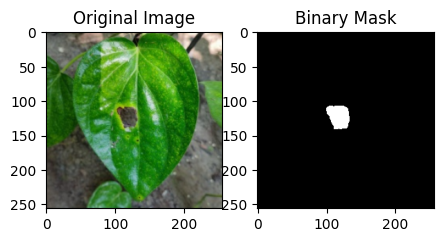

In [30]:
from matplotlib import pyplot as plt
# Visualize the first image and its corresponding binary mask
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_dataset[0])

plt.subplot(1, 2, 2)
plt.title('Binary Mask')
plt.imshow(mask_dataset[0], cmap='gray')

plt.show()


In [31]:
x_train, x_val, y_train, y_val = train_test_split(
    image_dataset, mask_dataset, test_size=0.45, random_state=SEED, shuffle=True
)
# Check shapes
print(f"Training images shape: {x_train.shape}")  # Should be (num_samples, 128, 128, 3)
print(f"Training masks shape: {y_train.shape}")   # Should be (num_samples, 128, 128, 1)
print(f"Validation images shape: {x_val.shape}")  # Should be (num_samples, 128, 128, 3)
print(f"Validation masks shape: {y_val.shape}")   # Should be (num_samples, 128, 128, 1)



Training images shape: (533, 256, 256, 3)
Training masks shape: (533, 256, 256, 1)
Validation images shape: (437, 256, 256, 3)
Validation masks shape: (437, 256, 256, 1)


In [32]:
# Training data augmentation
data_gen_args = dict(rotation_range=90.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.3,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

# Apply augmentation only for training data
X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)

# No augmentation for validation data
X_datagen_val = ImageDataGenerator()  # Default, no augmentation
Y_datagen_val = ImageDataGenerator()  # Default, no augmentation

# Fitting generators for training data
X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)

# Fitting generators for validation data (no augmentation)
X_datagen_val.fit(x_val, augment=False, seed=13)
Y_datagen_val.fit(y_val, augment=False, seed=13)

# Creating the data generators
X_train_augmented = X_datagen.flow(x_train, batch_size=8, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train, batch_size=8, shuffle=True, seed=13)

# Validation data without augmentation
X_train_augmented_val = X_datagen_val.flow(x_val, batch_size=8, shuffle=False, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_val, batch_size=8, shuffle=False, seed=13)

# Zip the augmented generators for training and validation
train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)


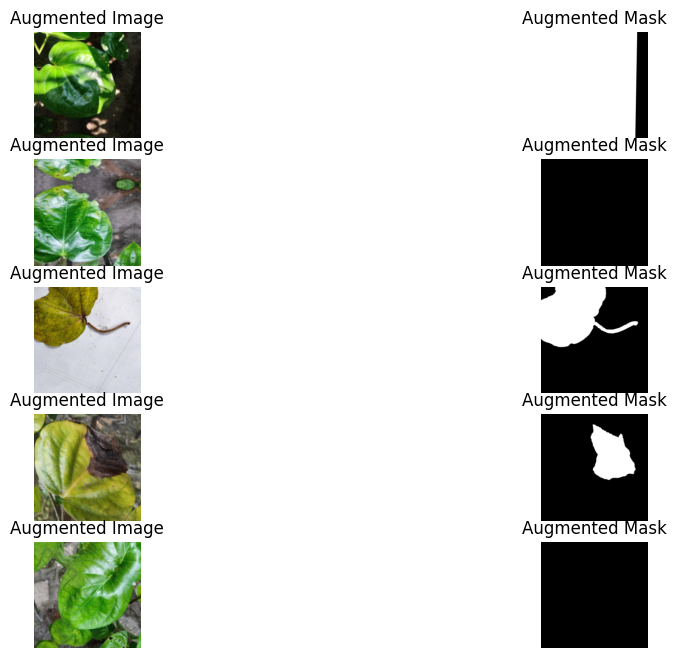

In [33]:
import matplotlib.pyplot as plt

def visualize_augmentation(generator, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        batch = next(generator)
        images = batch[0]
        masks = batch[1]

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[0])  # Display the first image of the batch
        plt.title('Augmented Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[0].squeeze(), cmap='gray')  # Display the first mask of the batch
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.show()

# Visualize augmented training images and masks
visualize_augmentation(train_generator, num_samples=5)


In [34]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

# Dice loss function for multiclass segmentation
def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # One-hot encode y_pred if it's not already
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return 1 - dice

# Combined loss: categorical cross-entropy + dice loss
def combined_multiclass_loss(y_true, y_pred):
    categorical_loss = CategoricalCrossentropy(from_logits=False)
    return categorical_loss(y_true, y_pred) + dice_loss_multiclass(y_true, y_pred)

# IOU metric for multiclass segmentation
def iou_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Dice coefficient metric for multiclass segmentation
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return dice


In [35]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.regularizers import l2



SIZE=256

def simple_unet_model_l2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, reg_value=0.001):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)

    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(c1)
    c1 = BatchNormalization()(c1)  # Batch Normalization
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(p1)
    c2 = BatchNormalization()(c2)  # Batch Normalization
    c2 = Activation('relu')(c2)

    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(c2)
    c2 = BatchNormalization()(c2)  # Batch Normalization
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(p2)
    c3 = BatchNormalization()(c3)  # Batch Normalization
    c3 = Activation('relu')(c3)

    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(c3)
    c3 = BatchNormalization()(c3)  # Batch Normalization
    c3 = Activation('relu')(c3)

    # Expansive path
    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(u6)
    c6 = BatchNormalization()(c6)  # Batch Normalization
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.1)(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(u7)
    c7 = BatchNormalization()(c7)  # Batch Normalization
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.1)(c7)

    outputs = Conv2D(4, (1, 1), activation='sigmoid')(c7)

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Define the input shape
input_shape = (SIZE, SIZE, 3)
model = simple_unet_model_l2(SIZE, SIZE, 3)

# Print the model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 256, 256, 16)   │             64 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 256, 256, 16)   │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 256, 256, 16)   │             64 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ activation_17[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 128, 128, 32)   │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128, 128, 32)   │              0 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128, 128, 32)   │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 106,612 (416.45 KB)

 Trainable params: 106,068 (414.33 KB)

 Non-trainable params: 544 (2.12 KB)

In [36]:
def combined_generator(image_gen, mask_gen):
    while True:
        X = image_gen.__next__()
        Y = mask_gen.__next__()
        if X.shape[0] == Y.shape[0]:

            Y = tf.one_hot(tf.cast(Y, tf.int32), depth=4)
            Y = tf.squeeze(Y, axis=3)
            yield X, Y

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented, Y_train_augmented),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # Changed to 4 channels
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented_val, Y_train_augmented_val),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # Changed to 4 channels
    )
)

# Instantiate the model
model = simple_unet_model_l2(SIZE, SIZE, 3)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_multiclass_loss,
              metrics=['accuracy', dice_coef_multiclass, iou_multiclass])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.5, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working//unet_original.keras', monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
EPOCHS = 100
BATCH_SIZE = 8
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE
)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1320 - dice_coef_multiclass: 0.3006 - iou_multiclass: 0.1775 - loss: 3.1721
Epoch 1: val_loss improved from inf to 2.60917, saving model to /kaggle/working//unet_original.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 0.1323 - dice_coef_multiclass: 0.3007 - iou_multiclass: 0.1776 - loss: 3.1703 - val_accuracy: 0.4213 - val_dice_coef_multiclass: 0.3341 - val_iou_multiclass: 0.2019 - val_loss: 2.6092 - learning_rate: 1.0000e-04
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2240 - dice_coef_multiclass: 0.3351 - iou_multiclass: 0.2017 - loss: 2.7642
Epoch 2: val_loss improved from 2.60917 to 2.40295, saving model to /kaggle/working//unet_original.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.2245 - dice_coef_multiclass: 0.3352 - iou_multiclass: 0.2018 - loss: 2.7631 - val_accuracy: 0.5444 - val_dice_coef_multiclass: 0.3697 - val_iou_multiclass: 0.2285 - val_loss: 2.4029 - le

In [37]:
# Print the final training/validation loss and accuracy values
print("Final Training Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])
print("Final Training Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Training Dice Coefficient: ", history.history['dice_coef_multiclass'][-1])
print("Final Validation Dice Coefficient: ", history.history['val_dice_coef_multiclass'][-1])
print("Final Training IoU: ", history.history['iou_multiclass'][-1])
print("Final Validation IoU: ", history.history['val_iou_multiclass'][-1])


Final Training Loss:  0.966776967048645
Final Validation Loss:  0.9407068490982056
Final Training Accuracy:  0.7586861848831177
Final Validation Accuracy:  0.7601668238639832
Final Training Dice Coefficient:  0.6922932267189026
Final Validation Dice Coefficient:  0.7079185247421265
Final Training IoU:  0.5349695086479187
Final Validation IoU:  0.5575528740882874


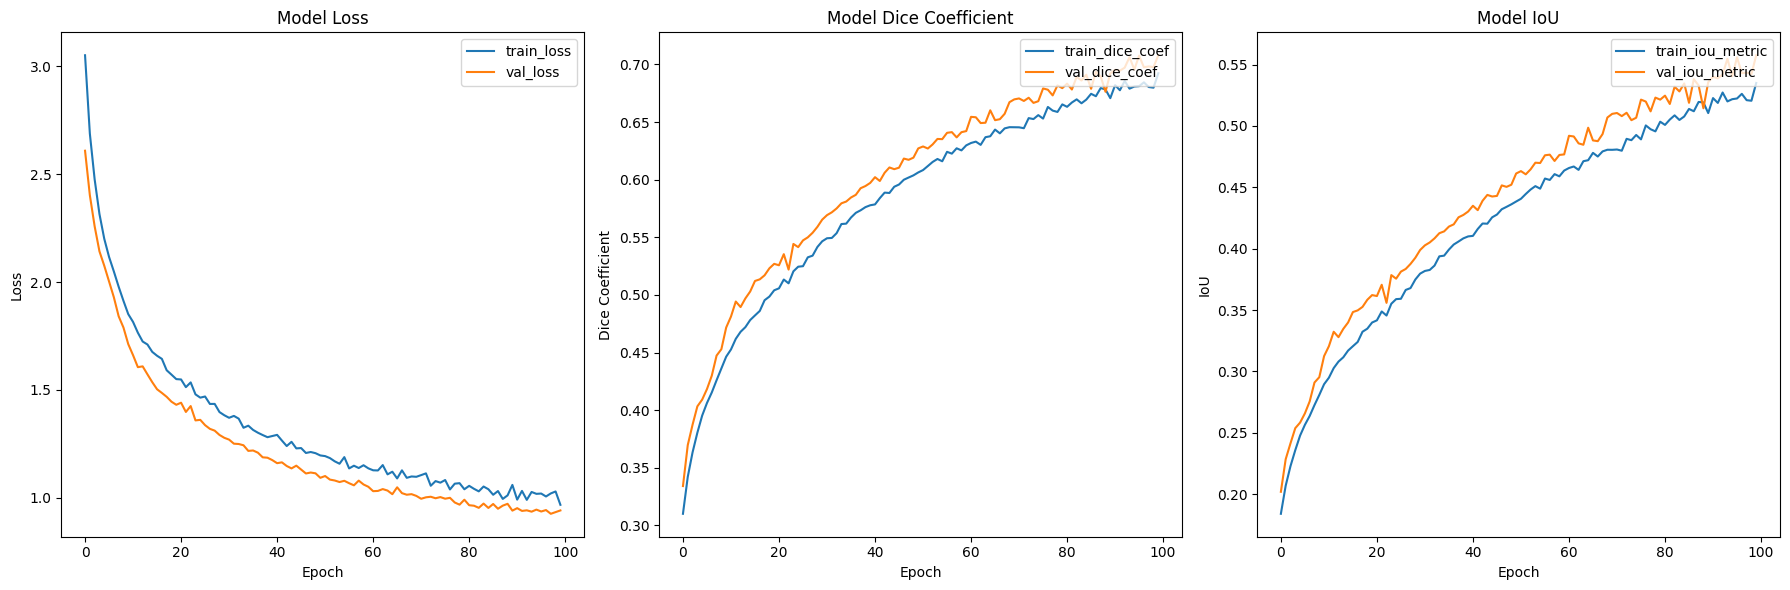

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation loss, dice coefficient, and IoU over epochs
def plot_training_history(history):
    # Summarize history for loss, dice coefficient, and IoU
    plt.figure(figsize=(18, 6))  # Increase figure size for 3 plots

    # Plot loss
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot Dice Coefficient
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
    plt.plot(history.history['dice_coef_multiclass'], label='train_dice_coef')
    plt.plot(history.history['val_dice_coef_multiclass'], label='val_dice_coef')
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot IoU
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
    plt.plot(history.history['iou_multiclass'], label='train_iou_metric')
    plt.plot(history.history['val_iou_multiclass'], label='val_iou_metric')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function to plot
plot_training_history(history)